In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.io.ascii as aio
import celerite2
import celerite2.theano
from celerite2.theano import terms as theano_terms
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import scipy.stats as ss
import seaborn as sns
import theano.tensor as T

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Here are some sensible parameters for Aldebaran:

In [3]:
mu_Hz_day = 1/(24.0*3600.0)*1e6

In [4]:
A_sun = 0.2 # m/s
Laldeb = 439 # LSun
Maldeb = 1.16 # MSun
Taldeb = 3900 # K
TSun = 5800 # K

A_aldeb_scaling = Laldeb / (Maldeb**1.5*(Taldeb/TSun)**2.25)
A_aldeb = 60.0 # 170 m/s is the RMS amplitude from Farr+(2018), but who knows how many modes it contains....
A_aldeb_scaling, A_aldeb

A_real = 100.0
f_real = 1.0

In [5]:
numax_aldeb = 2.33 # muHz
Dnu_sun = 135.0 # muHz
Dnu_aldeb = (Maldeb)**0.5*(Taldeb/TSun)**3/(Laldeb)**0.75*Dnu_sun
dnu_aldeb = 0.12*Dnu_aldeb
(numax_aldeb, Dnu_aldeb, dnu_aldeb)

(2.33, 0.4609185779612971, 0.05531022935535565)

A few properties of the oscillations:

In [6]:
print('Numax period: {:.1f} d'.format(mu_Hz_day/numax_aldeb))
print('Dnu_period: {:.1f} d'.format(mu_Hz_day/Dnu_aldeb))
print('dnu_period: {:.1f} d'.format(mu_Hz_day/dnu_aldeb))

Numax period: 5.0 d
Dnu_period: 25.1 d
dnu_period: 209.3 d


We need to be careful, because there aren't all that many large spacings that can fit into the frequencies smaller than $\nu_\mathrm{max}$:

In [7]:
numax_aldeb / Dnu_aldeb

5.055122773106464

In [74]:
Nmode = 3
Amode_total = 170
fmodes = array([numax_aldeb - (i-1)*Dnu_aldeb for i in range(Nmode)])
fmodes = sort(concatenate((fmodes, fmodes + dnu_aldeb)))
Amodes = exp(-0.5*square((fmodes - numax_aldeb)/Dnu_aldeb)) # Falloff with width Dnu_aldeb
Amodes = Amodes * 170 / sqrt(sum(square(Amodes)))
Q_true = 2*numax_aldeb / dnu_aldeb

kernel_true = sum([celerite2.terms.SHOTerm(sigma=A, Q=Q_true, w0=2*pi*f/(mu_Hz_day)) for (A, f) in zip(Amodes, fmodes)])
kernel_true = kernel_true + celerite2.terms.RealTerm(a=A_real*A_real, c=f_real/mu_Hz_day)
gp_true = celerite2.GaussianProcess(kernel_true)

We imagine that we observe once a week for a year, +/- 2 days, with uncertainty that is 2.5 +/- 0.5 m/s (comparable to Song).  For whatever reason, 25% of the measurements are dropped (bad week, whatever).

In [75]:
t_obs = arange(0, 365.25, 7)
t_obs = t_obs + random.uniform(low=-2, high=2, size=len(t_obs))
t_obs = t_obs[rand(len(t_obs)) > 0.25]

sigma_obs = 2.5 + random.uniform(low=-0.5, high=0.5, size=len(t_obs))

<ErrorbarContainer object of 3 artists>

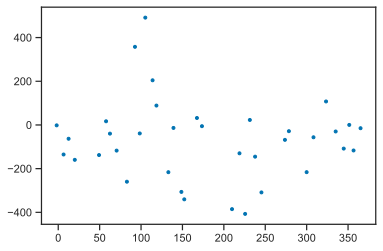

In [76]:
gp_true.compute(t_obs, yerr=sigma_obs)
rv_obs = gp_true.sample()

errorbar(t_obs, rv_obs, yerr=sigma_obs, fmt='.')

Here is the true PSD:

Text(0, 0.5, '$P(f) / \\mathrm{m}^2 \\, \\mathrm{s}^{-2} \\, \\mu\\mathrm{Hz}^{-1}$')

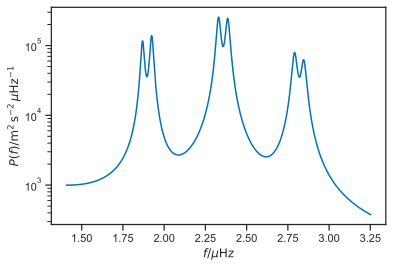

In [77]:
fs = linspace(numax_aldeb - (Nmode//2 + 1)*Dnu_aldeb, numax_aldeb + (Nmode//2 + 1)*Dnu_aldeb, 1024)
psd_true = gp_true.kernel.get_psd(2*pi*fs/mu_Hz_day)*2*pi/mu_Hz_day

plot(fs, psd_true)
yscale('log')
xlabel(r'$f / \mu\mathrm{Hz}$')
ylabel(r'$P(f) / \mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$')

Let's build a model!

In [78]:
t_pred = linspace(min(t_obs), max(t_obs), 1024)
with pm.Model() as model_aldeb:
    f0 = pm.Lognormal('f0', mu=log(min(fmodes)), sigma=1)
    
    Amax = pm.Lognormal('Amax', mu=log(300), sigma=1)
    fmax = pm.Lognormal('fmax', mu=log(numax_aldeb), sigma=1)
    sigma_f = pm.Lognormal('sigma_f', mu=log(Dnu_aldeb), sigma=1)
    
    Q = pm.Lognormal('Q', mu=log(Q_true), sigma=1)
    
    Areal = pm.Lognormal('Areal', mu=log(A_real), sigma=1)
    freal = pm.Lognormal('freal', mu=log(f_real), sigma=1)
    
    Df = pm.Lognormal('Df', mu=log(Dnu_aldeb), sigma=1)
    df = pm.Lognormal('df', mu=log(dnu_aldeb), sigma=1)
    
    k = celerite2.theano.terms.RealTerm(a=Areal*Areal, c=freal/mu_Hz_day)
    for i in range(Nmode):
        f = f0 + float(i)*Df
        A = Amax*T.exp(-0.5*T.square((f-fmax)/sigma_f))
        k = k + celerite2.theano.terms.SHOTerm(sigma=A, Q=Q, w0=2*pi*f/mu_Hz_day)
        
        f2 = f + df
        A2 = Amax*T.exp(-0.5*T.square((f2-fmax)/sigma_f))
        k = k + celerite2.theano.terms.SHOTerm(sigma=A2, Q=Q, w0=2*pi*f2/mu_Hz_day)
    gp = celerite2.theano.GaussianProcess(k)
    
    gp.compute(t_obs, yerr=sigma_obs)
    gp.marginal('rv_obs', observed=rv_obs)
    
    resid = pm.Deterministic('residual', rv_obs - gp.predict(rv_obs, t=t_obs))
    psd = pm.Deterministic('PSD', gp.kernel.get_psd(2*pi*fs/mu_Hz_day)*2*pi/mu_Hz_day)
    rv_pred = pm.Deterministic('rv_pred', gp.predict(rv_obs, t=t_pred))

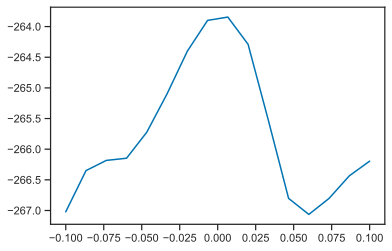

In [79]:
x = model_aldeb.bijection.map(model_aldeb.test_point)

i = 8
e = zeros_like(x)
e[i] = 1

d = linspace(-1e-1, 1e-1, 16)
lp = [model_aldeb.logp_array(x + dd*e) for dd in d]
plot(d, lp)

In [80]:
model_aldeb.logp_array(x)

array(-263.82580945)

In [81]:
with model_aldeb:
    pbest, info = pmx.optimize(return_info=True)

optimizing logp for variables: [df, Df, freal, Areal, Q, sigma_f, fmax, Amax, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: -263.8258094478326 -> -261.88189322778527


In [82]:
with model_aldeb:
    pbest, info = pmx.optimize(return_info=True)

optimizing logp for variables: [df, Df, freal, Areal, Q, sigma_f, fmax, Amax, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: -263.8258094478326 -> -263.8258094478326


In [83]:
info

      fun: 263.8258094478326
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([-9.55609291e+00, -9.72387291e+00,  1.31520840e-01,  2.19390745e+00,
       -5.10154102e+00,  1.36872780e+01, -1.38107357e+00,  3.46962030e+01,
        3.70446671e+02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 16
      nit: 0
     njev: 5
   status: 2
  success: False
        x: array([-2.89479741, -0.77453387,  0.        ,  4.60517019,  4.43381286,
       -0.77453387,  0.84586827,  5.70378247,  0.62544709])

In [53]:
model_aldeb.dlogp_array(model_aldeb.bijection.map(pbest))

array([ 3.97086867e+00, -1.72427694e+02,  1.60698359e-01, -2.95598949e+00,
        2.66124234e+00, -1.59696486e+01, -1.64566233e+01, -2.91363610e+01,
       -1.97801882e+02])

In [55]:
x = model_aldeb.bijection.map(pbest) + 0.001*model_aldeb.dlogp_array(model_aldeb.bijection.map(pbest))
model_aldeb.logp_array(model_aldeb.bijection.map(pbest)), model_aldeb.logp_array(x)

(array(-299.35308443), array(nan))

In [52]:
model_aldeb.bijection.rmap(pbest), model_aldeb.bijection.rmap(x)

{'f0_log__': array(-96371409.02591856),
 'Amax_log__': array(13907807.6374381),
 'fmax_log__': array(31123978.99920838),
 'sigma_f_log__': array(-1228771.46645196),
 'Q_log__': array(1374285.97929867),
 'Areal_log__': array(3627115.37155553),
 'freal_log__': array(-1691387.28138959),
 'Df_log__': array(-2.87175133e+08),
 'df_log__': array(-2176013.3058547)}

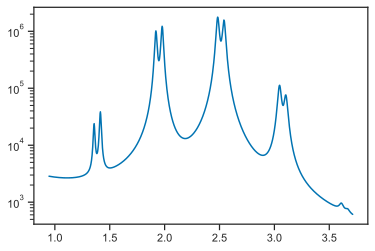

In [35]:
plot(fs, pbest['PSD'])
yscale('log')

Text(0, 0.5, '$v_r - v_{r,\\mathrm{pred}} / \\mathrm{m} \\, \\mathrm{s}^{-1}$')

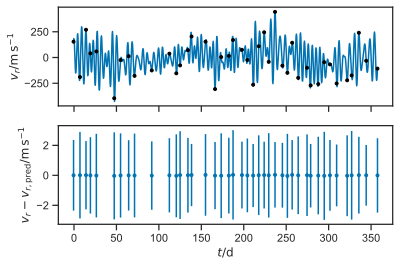

In [45]:
fig, [ax1, ax2] = subplots(nrows=2, ncols=1, sharex=True)
ax1.errorbar(t_obs, rv_obs, yerr=sigma_obs, fmt='.', color='k')
ax1.plot(t_pred, pbest['rv_pred'])
ax2.errorbar(t_obs, pbest['residual'], yerr=sigma_obs, fmt='.')
ax2.set_xlabel(r'$t / \mathrm{d}$')
ax1.set_ylabel(r'$v_r / \mathrm{m} \, \mathrm{s}^{-1}$')
ax2.set_ylabel(r'$v_r - v_{r,\mathrm{pred}} / \mathrm{m} \, \mathrm{s}^{-1}$')

In [46]:
with model_aldeb:
    trace = pmx.sample()

/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [df, Df, freal, Areal, Q, sigma_f, fmax, Amax, f0]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 88 seconds.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7981724148277689, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f0'}>],
       [<AxesSubplot:title={'center':'Amax'}>,
        <AxesSubplot:title={'center':'Amax'}>],
       [<AxesSubplot:title={'center':'fmax'}>,
        <AxesSubplot:title={'center':'fmax'}>],
       [<AxesSubplot:title={'center':'sigma_f'}>,
        <AxesSubplot:title={'center':'sigma_f'}>],
       [<AxesSubplot:title={'center':'Q'}>,
        <AxesSubplot:title={'center':'Q'}>],
       [<AxesSubplot:title={'center':'Areal'}>,
        <AxesSubplot:title={'center':'Areal'}>],
       [<AxesSubplot:title={'center':'freal'}>,
        <AxesSubplot:title={'center':'freal'}>],
       [<AxesSubplot:title={'center':'Df'}>,
        <AxesSubplot:title={'center':'Df'}>],
       [<AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'df'}>]], dtype=object)

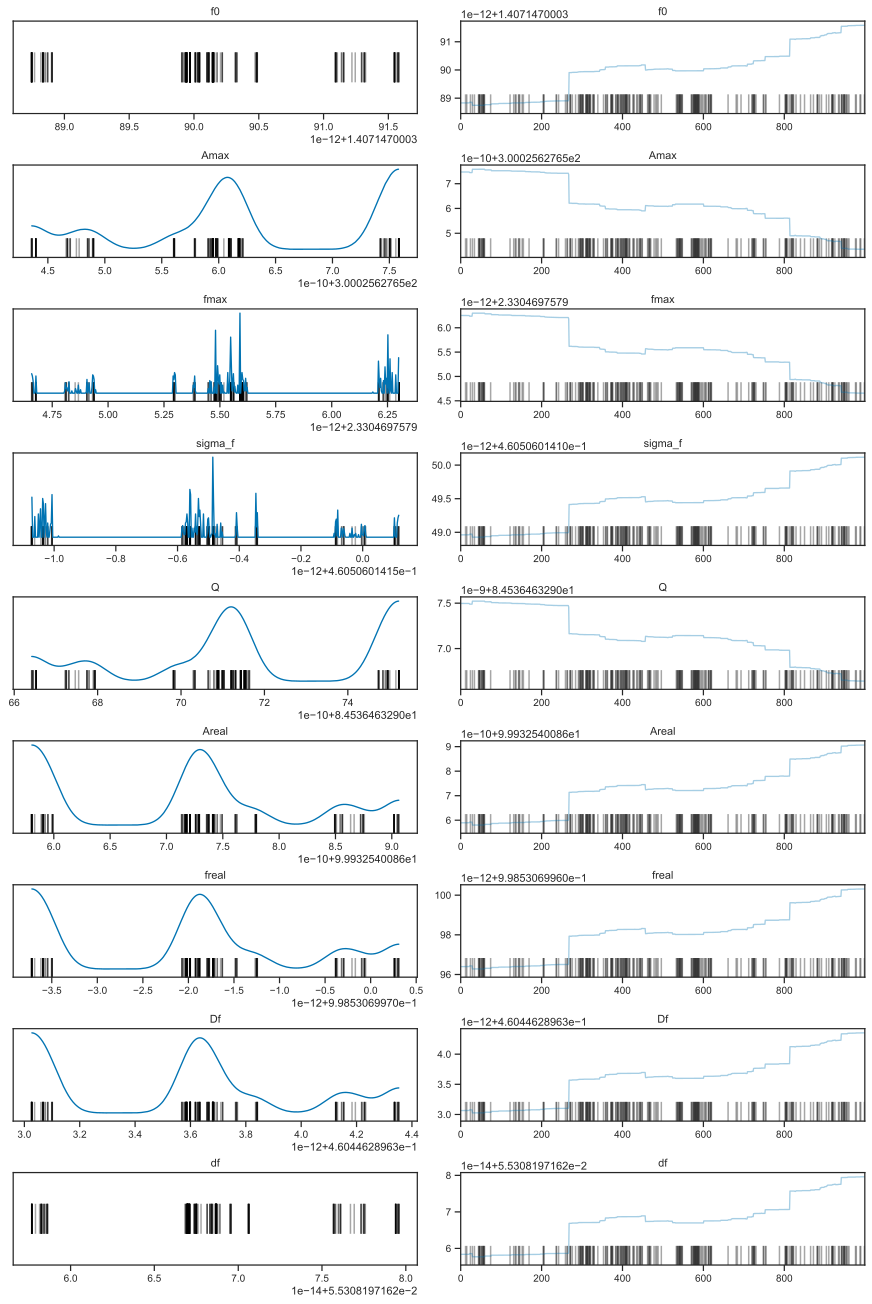

In [47]:
pm.plot_trace(trace, var_names=['f0', 'Amax', 'fmax', 'sigma_f', 'Q', 'Areal', 'freal', 'Df', 'df'])